When performing cluster analysis on information in files with DBSCAN, the usefulness of the results depends significantly on the values chosen for `eps` and `min_samples`. If these values are not appropriate for the file being analyzed, DBSCAN may not find meaningful clusters in the data. For example, if all of the data in a complex program is assigned the same cluster label, little insight can be gained into what kind of information is actually stored in the file. **The main challenge is finding clusters while preserving their relationship with the underlying data type**. Finding many clusters is nice and all, but if they do not reflect anything real then there is no point. Settings that produce too many small clusters or too few large ones are both less than ideal and do not lend themselves to accurate analysis. In sum, the goal is not to find as many clusters as possible but rather to find clusters that tell us something meaningful about what kind of data is in the binary file.


To demonstrate this, we can analyze Linux utilities `cat` and `readelf`.

A good general introduction to DBSCAN (example code is in R, unfortunately) can be found here: [DBSCAN: density-based clustering for discovering clusters in large datasets with noise - Unsupervised Machine Learning](http://www.sthda.com/english/wiki/wiki.php?id_contents=7940)

<h2>Choosing eps and min_samples when analyzing cat (35Kb)</h2>

The first step is loading the file into memory, partitioning it and measuring cluster features:

In [1]:
import sys
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [16, 9]  # we want large, uniformly-sized plots

sys.path[0:0] = ['.', '..']               # the centrifuge library files are located in ../centrifuge

from centrifuge.binfile import BinFile

In [2]:
file_handle = open("/bin/cat", "rb")
cat = BinFile(file_handle)

In [3]:
cat.slice_file()

`cat` is a fairly small file, only ~35 kilobytes in size. Compared to this, firmware for routers running embedded Linux are often several megabytes in size. This matters because file size determines how many blocks a file is partitioned into; the fewer blocks to measure, the smaller clusters will be. This means that the value of `min_samples` will usually need to be chosen to reflect file size - the smaller the file, the smaller the value of `min_samples`.

Let us begin `eps` = 1 and `min_samples` = 10:

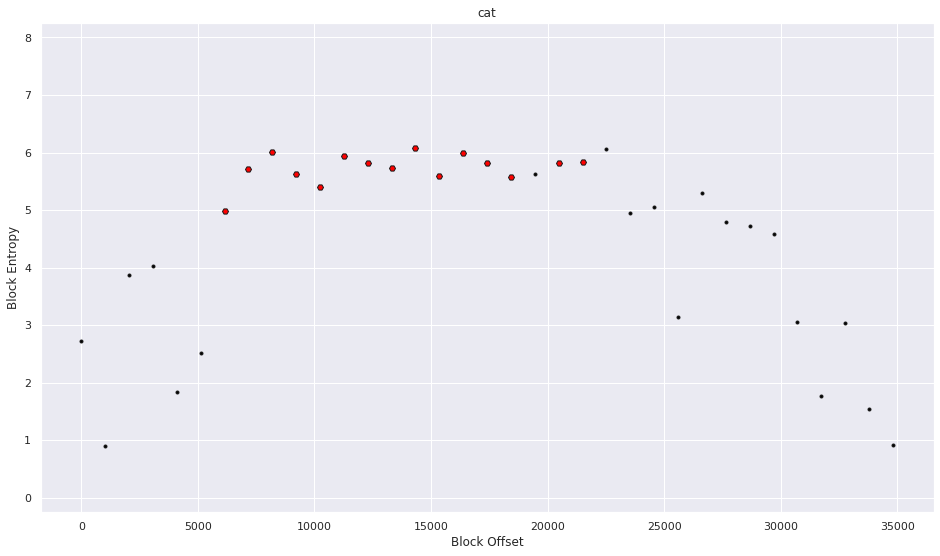

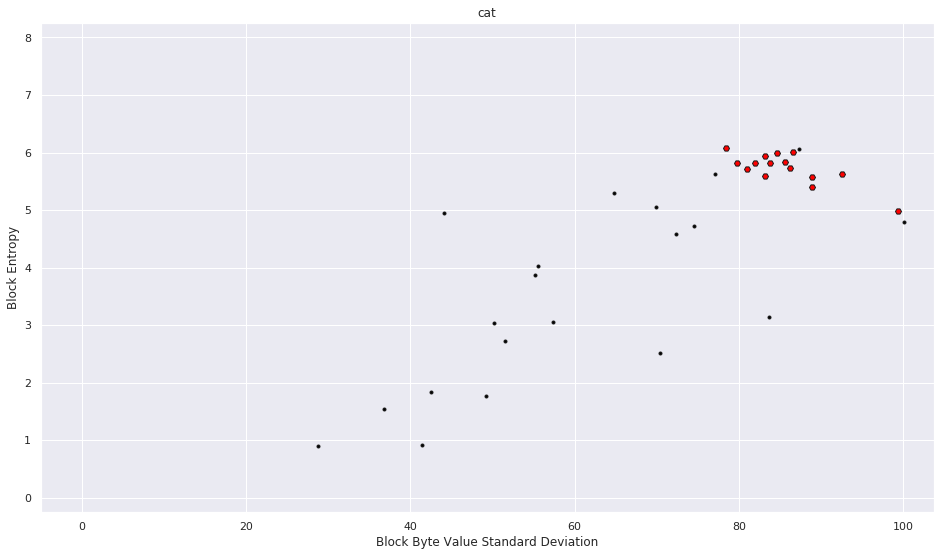

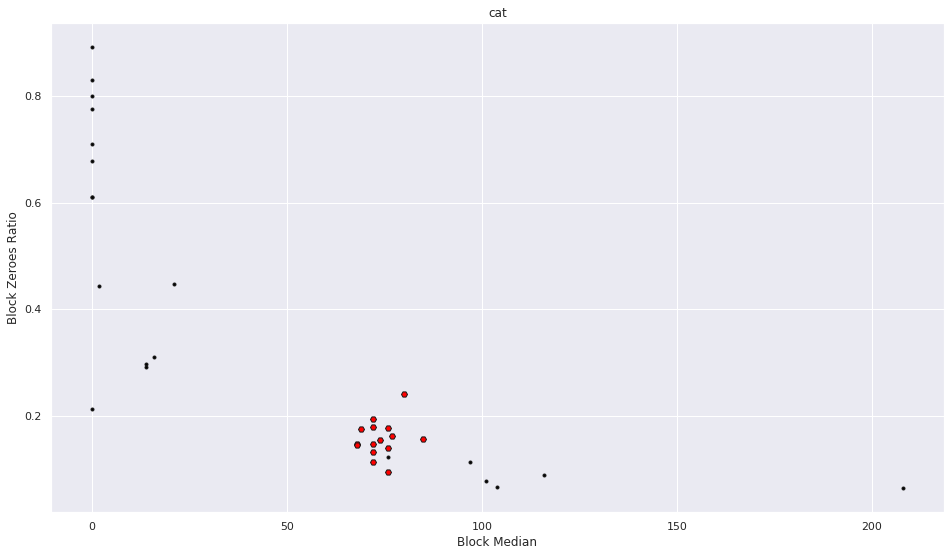

In [4]:
cat.cluster_DBSCAN(epsilon=1,
                   minimum_samples=10,
                   find_optimal_epsilon=False)
cat.plot_DBSCAN_results()

1 cluster is found, which contains machine code. However, it is possible to find other clusters if `min_samples` is smaller:

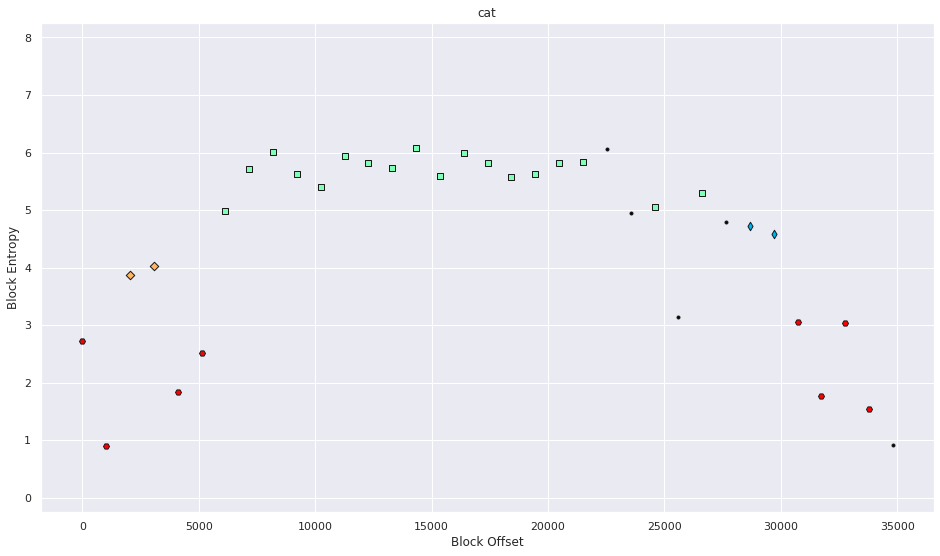

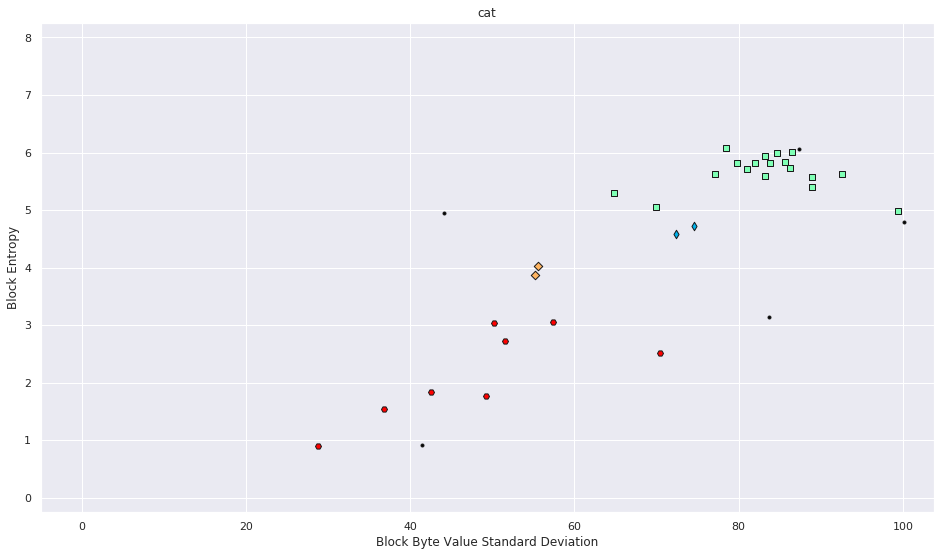

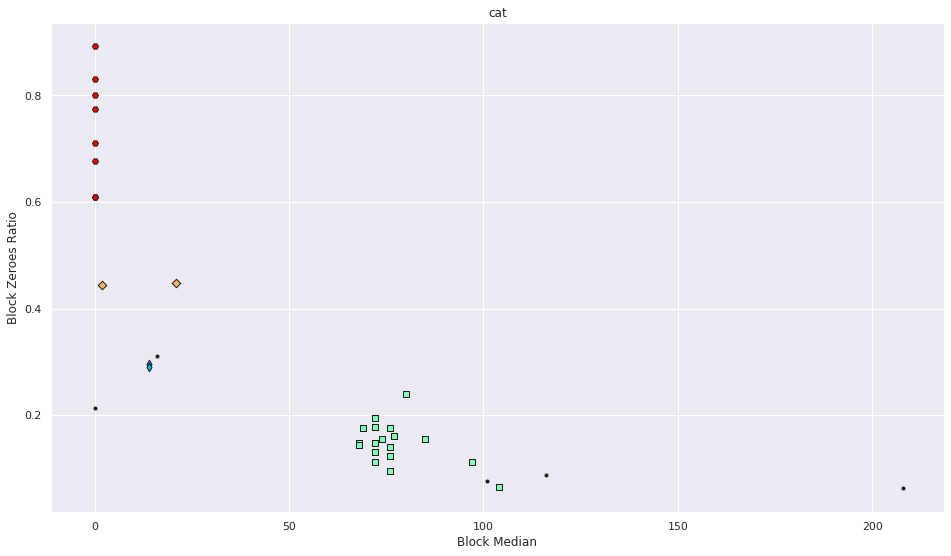

In [5]:
cat.cluster_DBSCAN(epsilon=1,
                   minimum_samples=2,
                   find_optimal_epsilon=False)
cat.plot_DBSCAN_results()

4 clusters now appear.

How about adjusting `eps`? Something that can help is a "knee plot", which is output when `find_optimal_epsilon` is set to `True`:

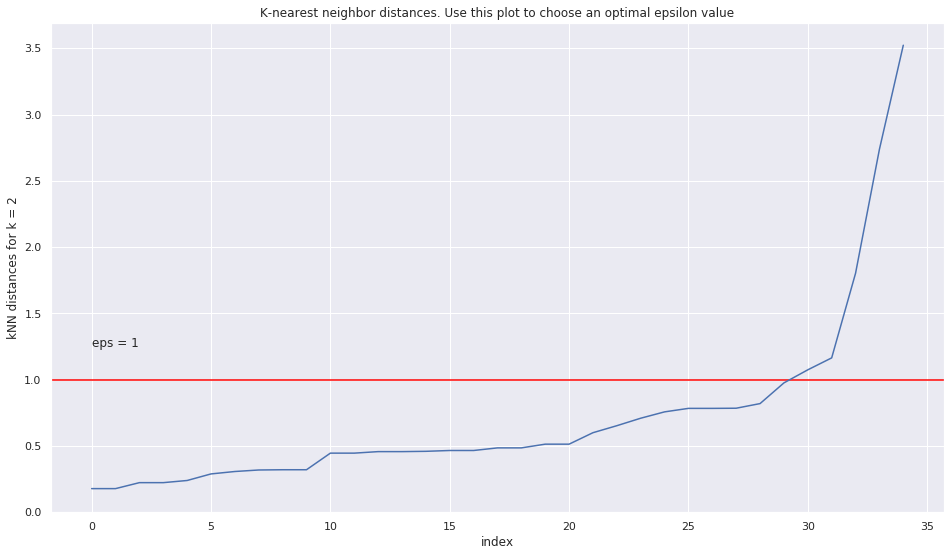

In [6]:
cat.cluster_DBSCAN(1,
                   2,
                   find_optimal_epsilon=True)

For our purposes here, `eps` can be set to a lower value:

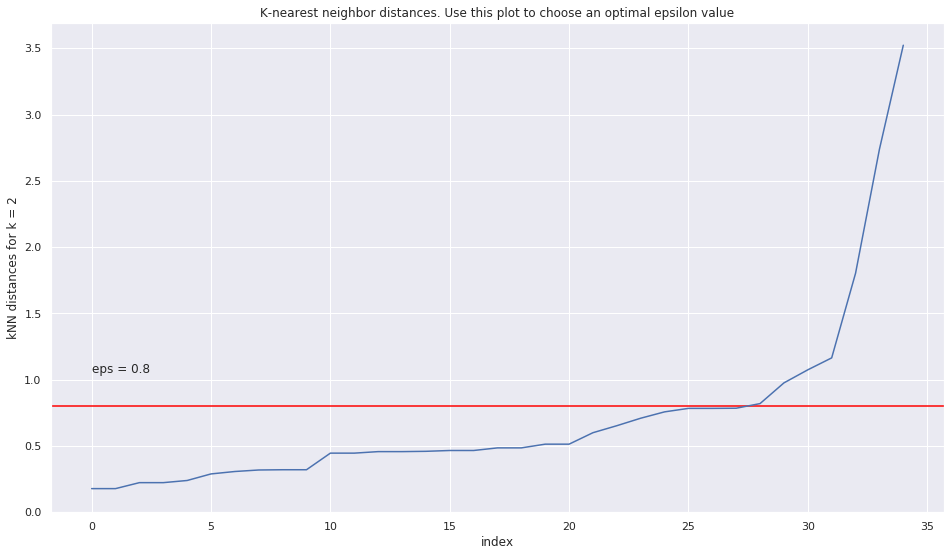

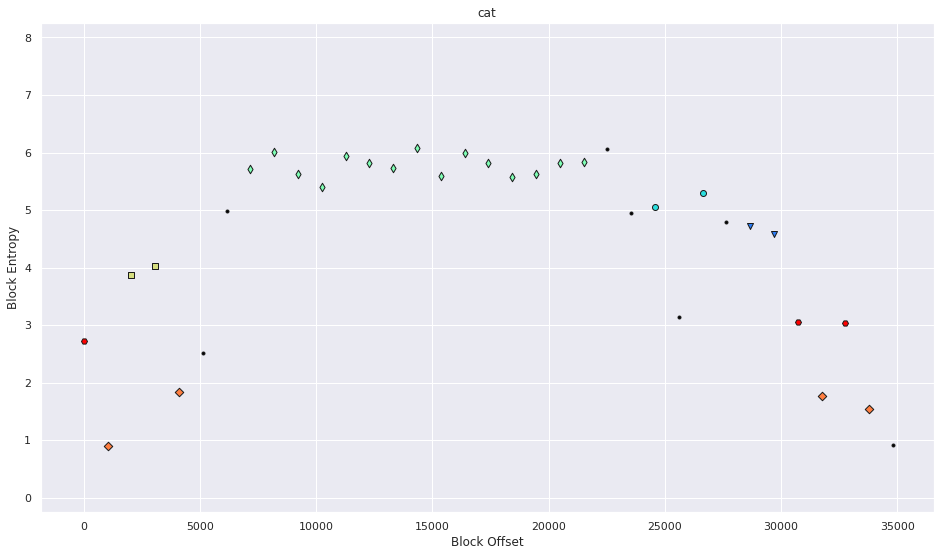

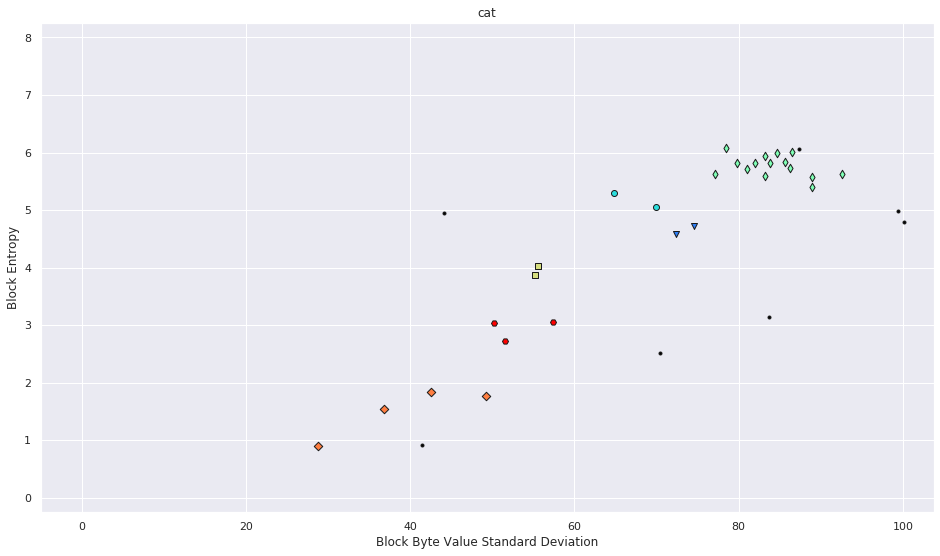

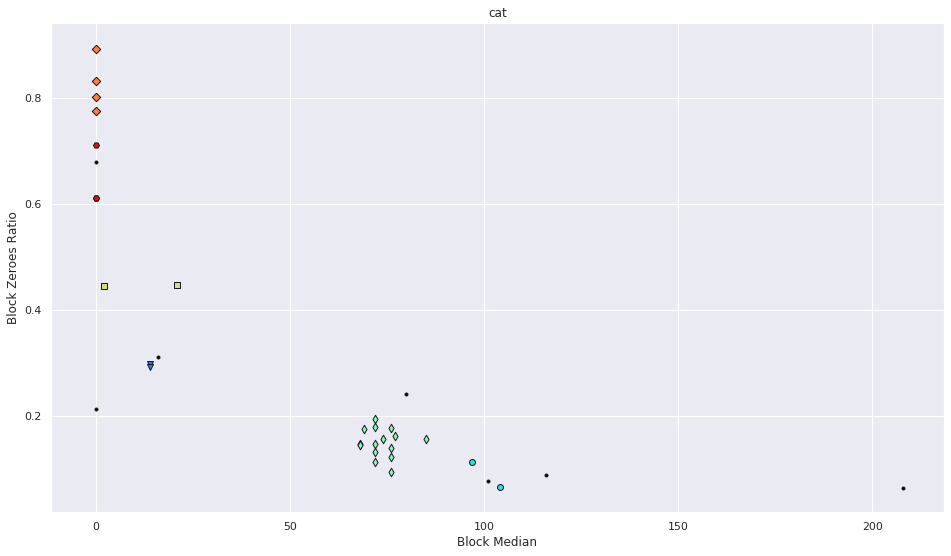

In [7]:
cat.cluster_DBSCAN(epsilon=0.8,
                   minimum_samples=2,
                   find_optimal_epsilon=True)
cat.plot_DBSCAN_results()

We now have 6 different clusters to work with, each with a unique distribution. However, this may not necessarily be as helpful as the results above, in which 4 clusters were identified. For example, when we look at the CDF plots below, we observe that clusters 0 and 1 are quite similar, as well as clusters 2 and 4. These extra clusters may be redundant.

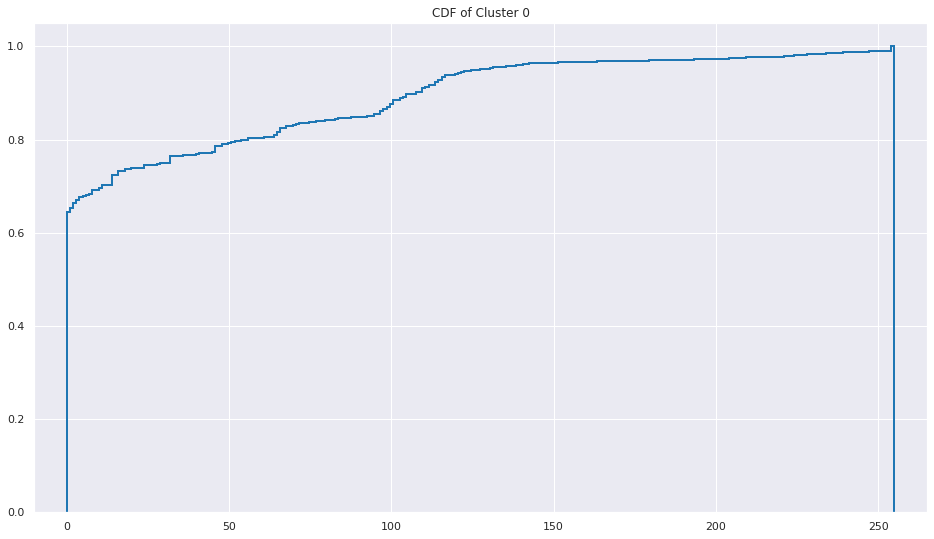

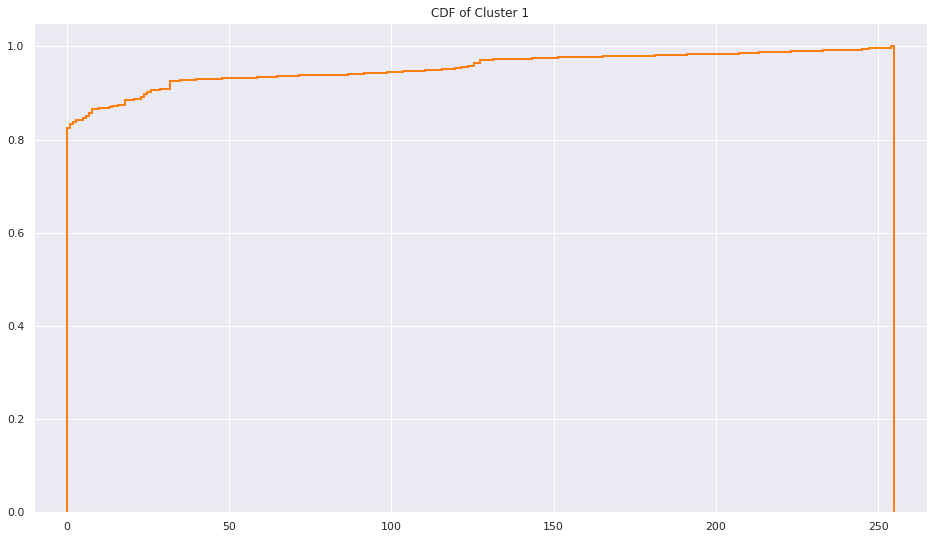

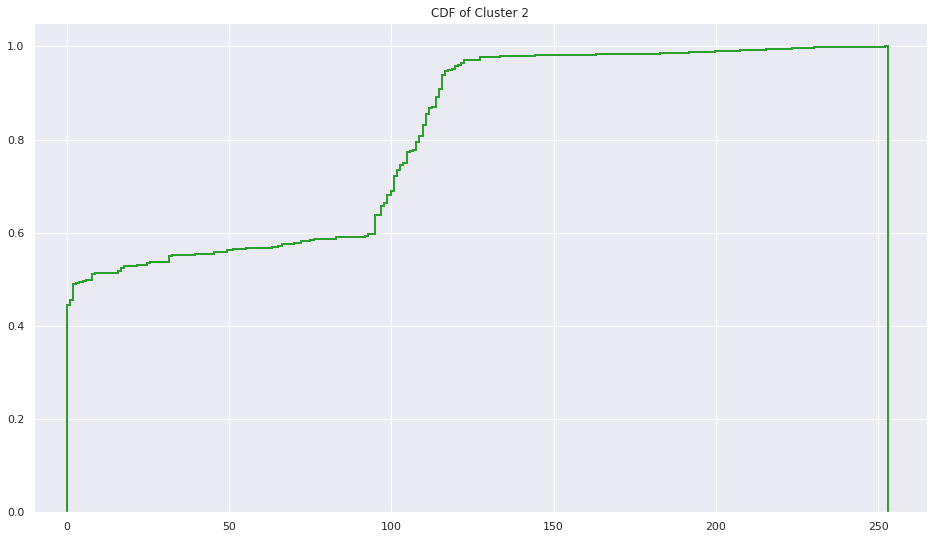

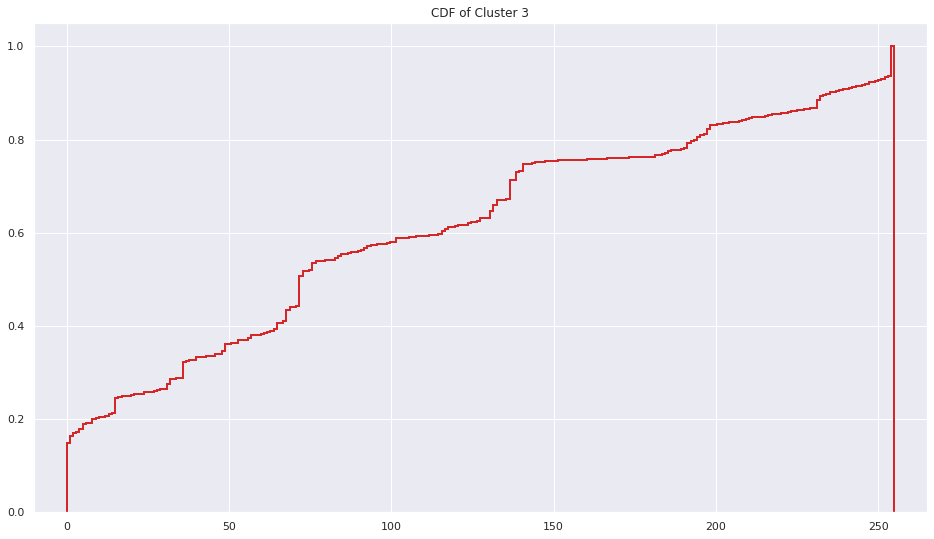

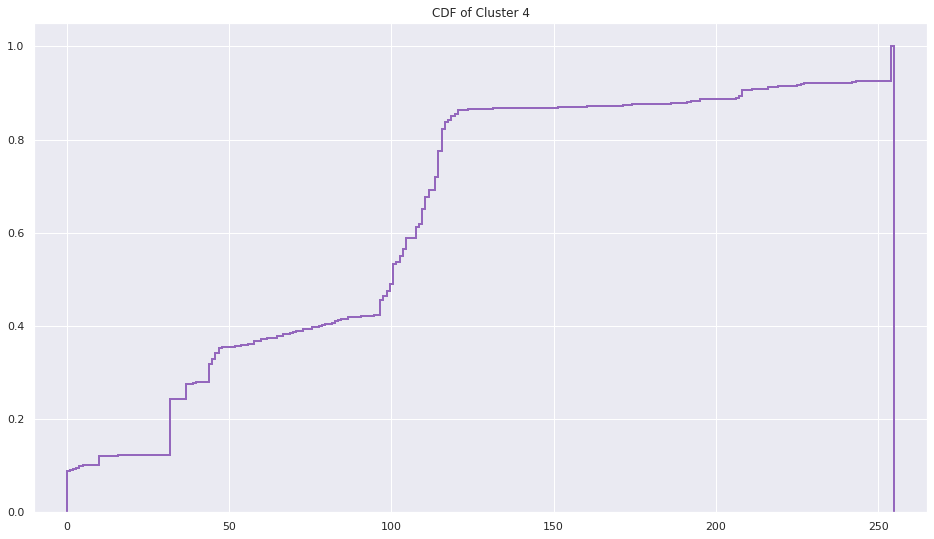

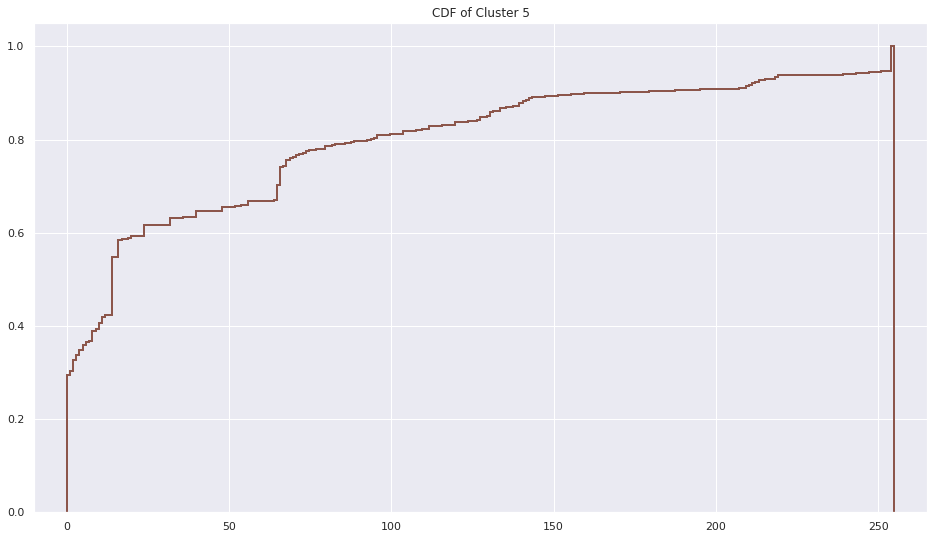

In [8]:
cat.plot_cluster_cdfs()

In [20]:
_ = cat.identify_cluster_data_types()

Searching for machine code
--------------------------------------------------------------------

[+] Checking Cluster 3 for possible match
[+] Closely matching CPU architecture reference(s) found for Cluster 3
[+] Sending sample to https://isadetect.com/
[+] response:

{
    "prediction": {
        "architecture": "amd64",
        "endianness": "little",
        "wordsize": 64
    },
    "prediction_probability": 0.99
}


Searching for utf8-english data
-------------------------------------------------------------------

[+] UTF-8 (english) detected in Cluster 4
    Wasserstein distance to reference: 25.253429687500002


Searching for high entropy data
-------------------------------------------------------------------

[X] No high entropy data cluster detected.



In [21]:
file_handle.close()

<hr>

<h2>Choosing eps and min_samples when analyzing readelf (583Kb)</h2>

`readelf` is a much larger file, so it is likely that different values for `eps` and `min_samples` should be chosen.

In [24]:
file_handle = open("/usr/bin/x86_64-linux-gnu-readelf", "rb")
readelf = BinFile(file_handle)

In [25]:
readelf.slice_file()

First, let us choose an unreasonably large `eps` value:

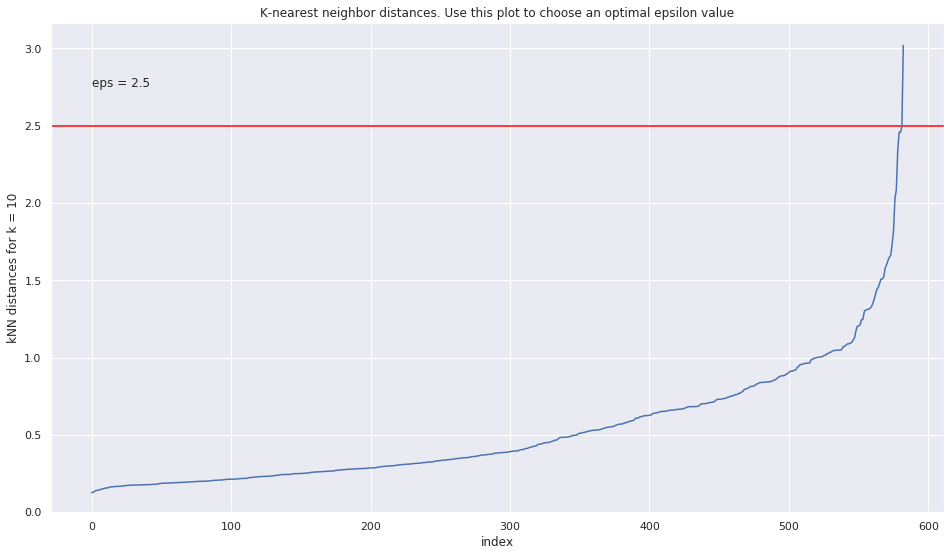

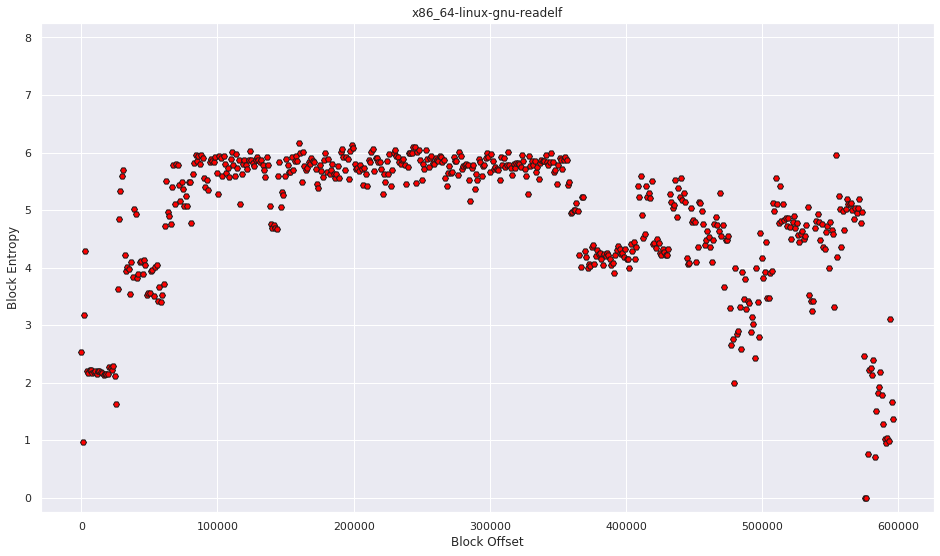

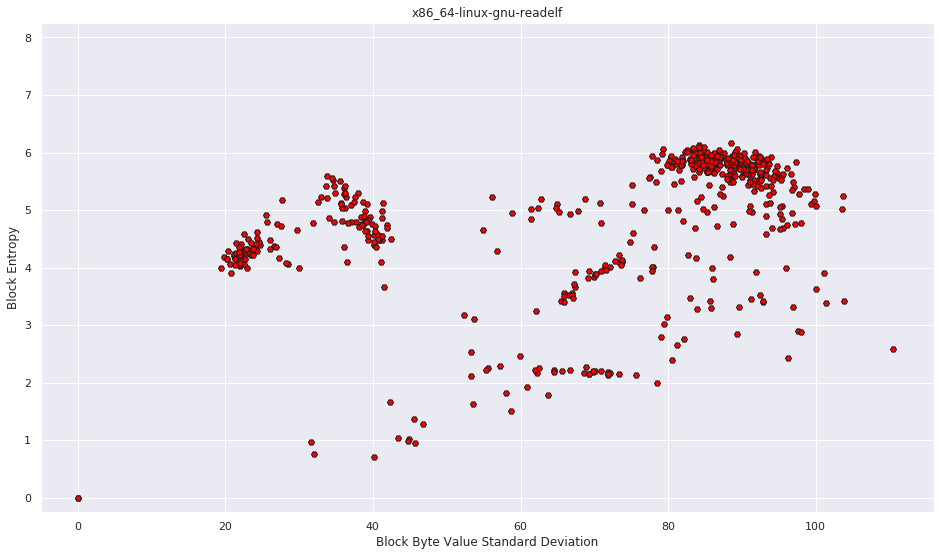

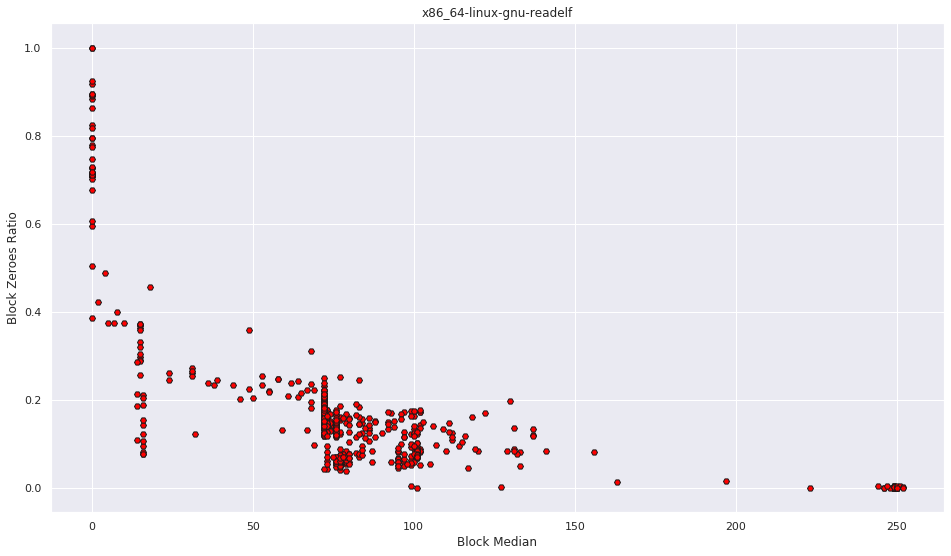

In [26]:
readelf.cluster_DBSCAN(epsilon=2.5,
                       minimum_samples=10,
                       find_optimal_epsilon=True)
readelf.plot_DBSCAN_results()

Obviously, this is not a good choice. Several areas that should be separate clusters are lumped into one big one. 

Let us try an `eps` value of 1 and a `min_samples` value of 10:

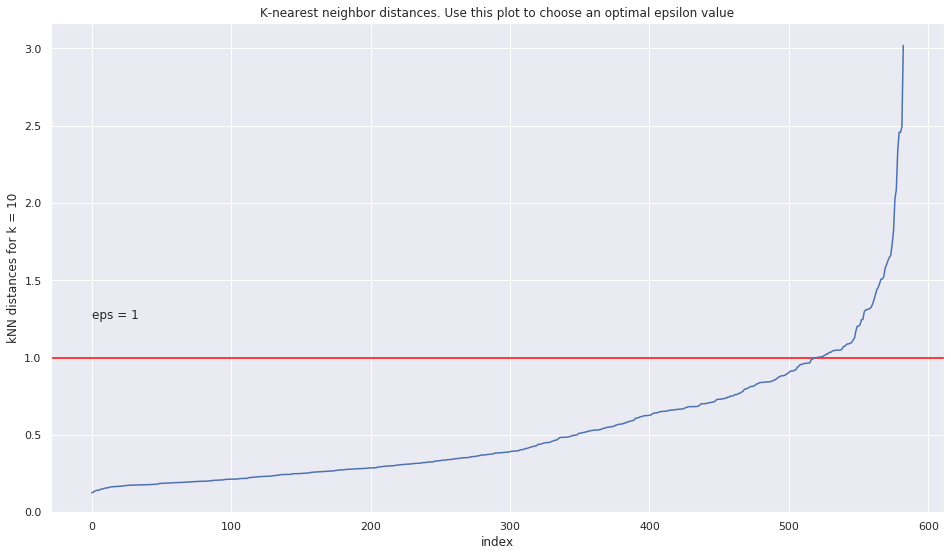

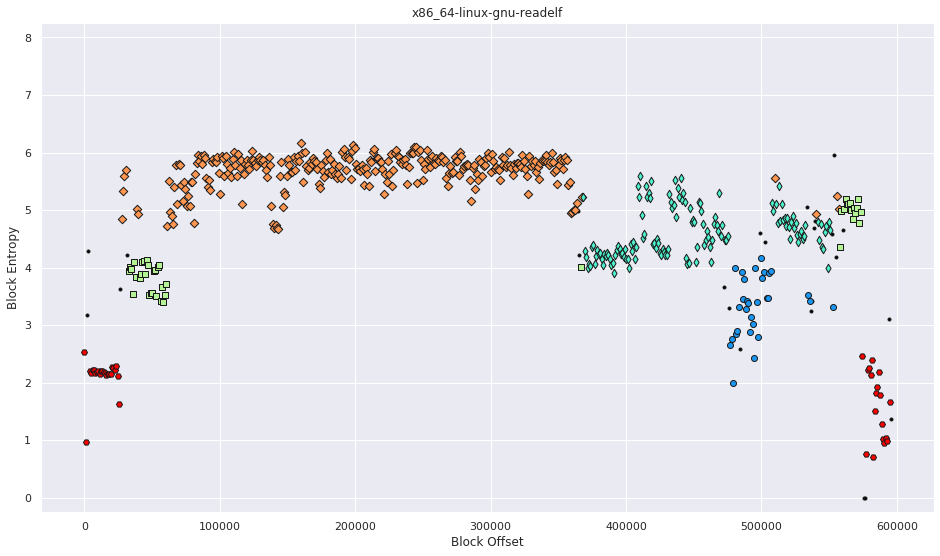

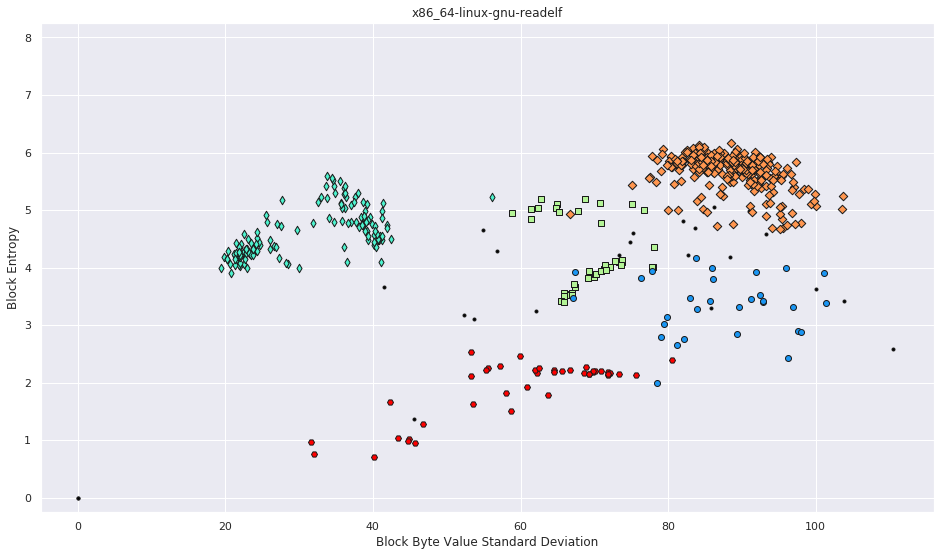

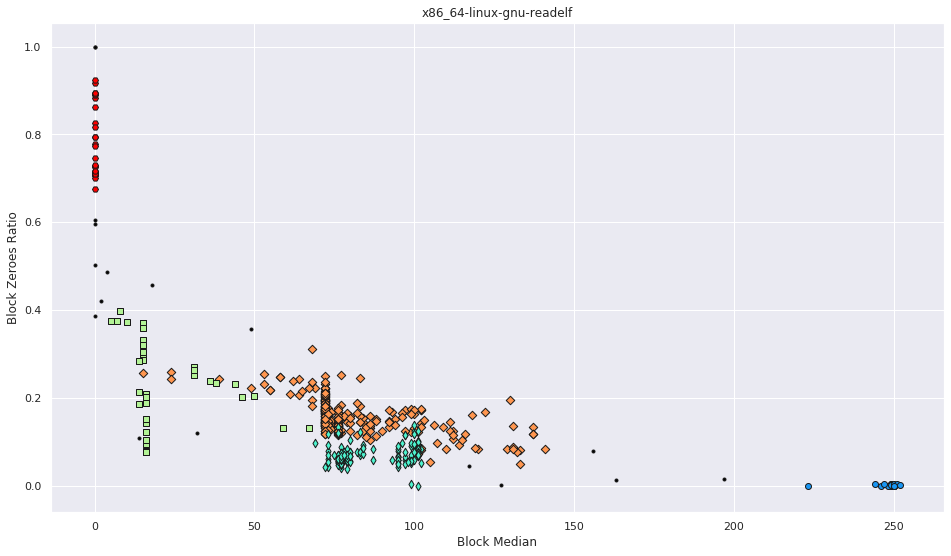

In [27]:
readelf.cluster_DBSCAN(epsilon=1,
                       minimum_samples=10,
                       find_optimal_epsilon=True)
readelf.plot_DBSCAN_results()

An `eps` of 1 still looks to be too permissive because the clusters are not very cohesive - some of the clusters appear scattered. The tighter the clusters, the more accurate analysis will be. Let us choose something smaller:

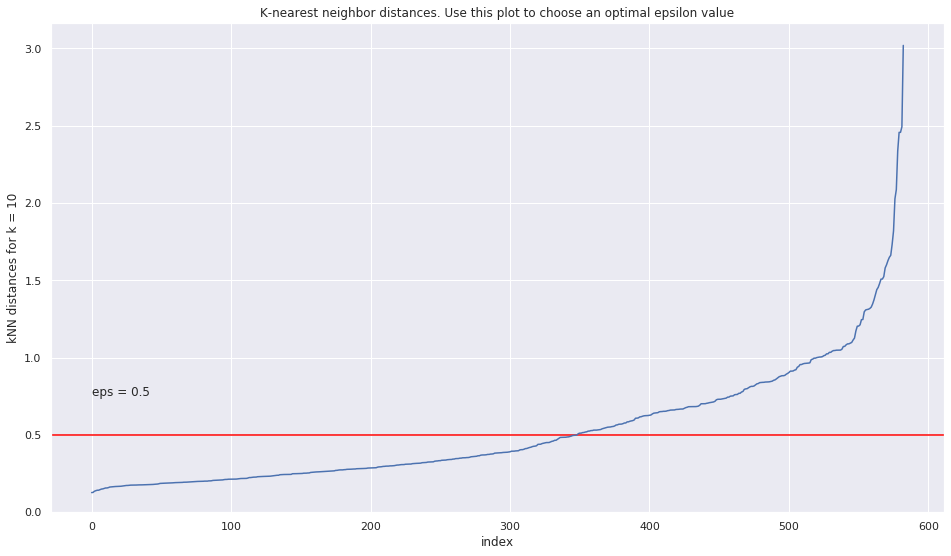

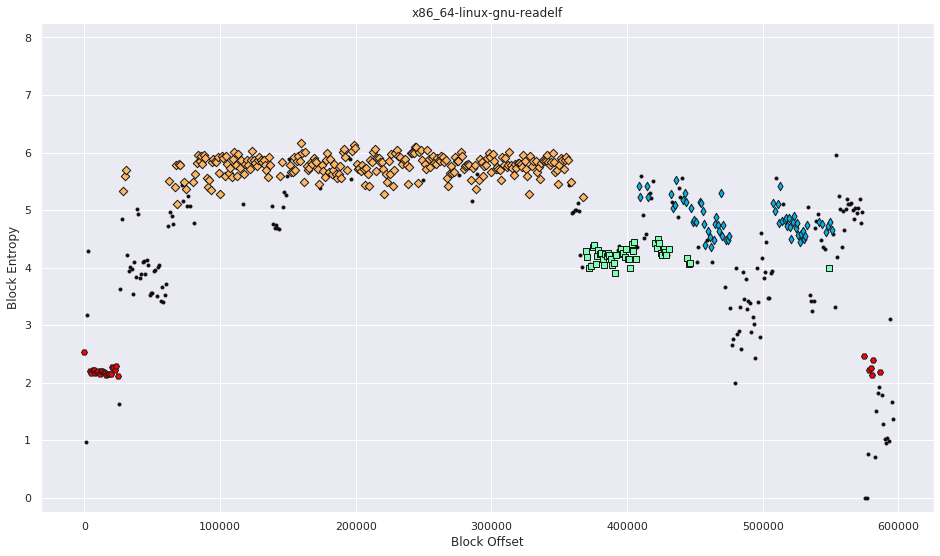

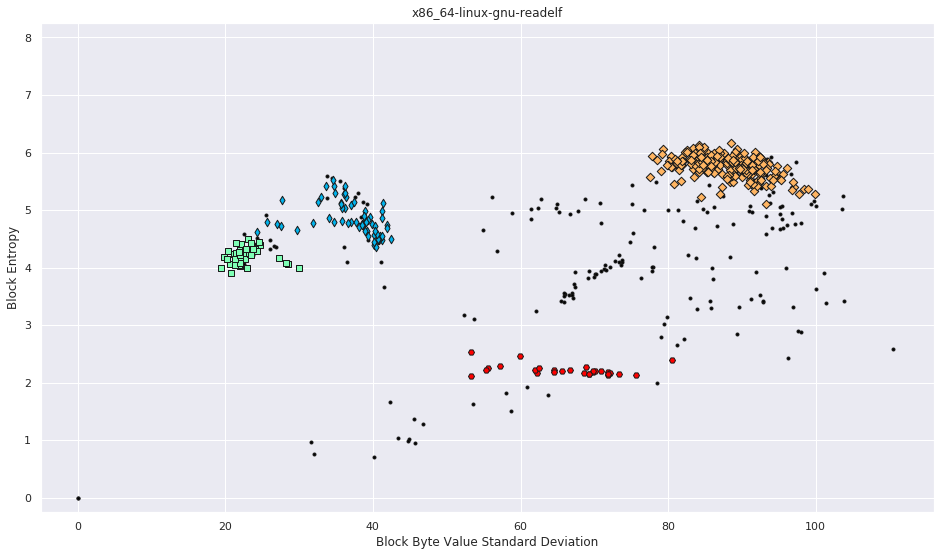

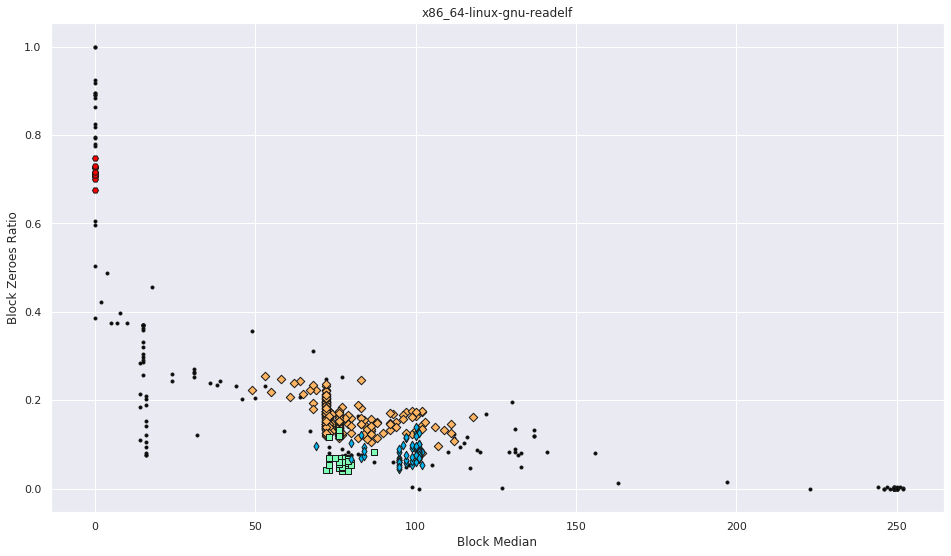

In [28]:
readelf.cluster_DBSCAN(0.5,
                       10,
                       find_optimal_epsilon=True)
readelf.plot_DBSCAN_results()

This looks better, but it also appears that we miss some clusters. Now let us choose a smaller calue for `min_samples`:

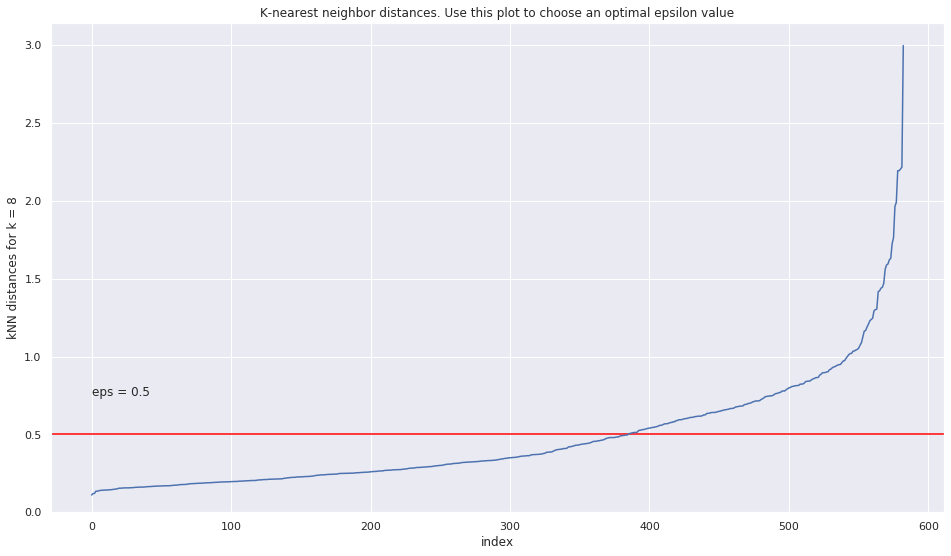

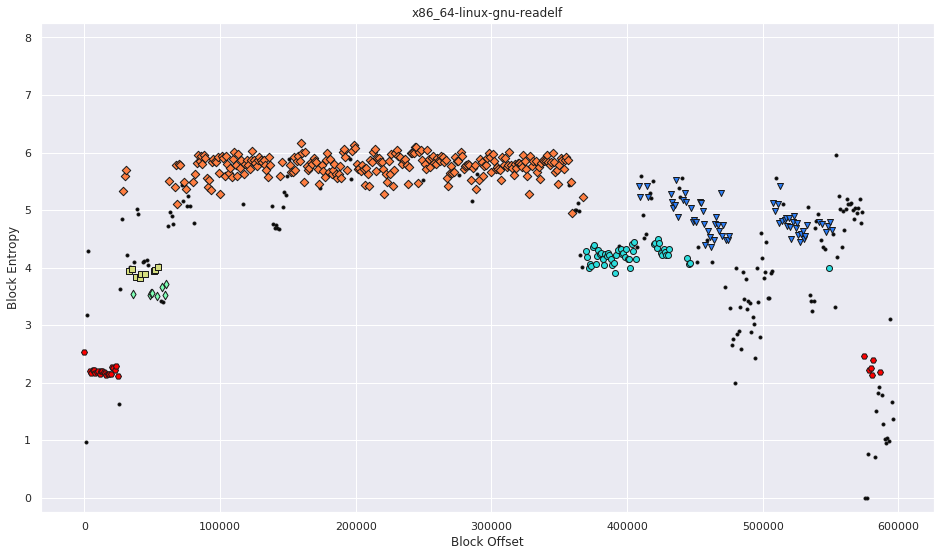

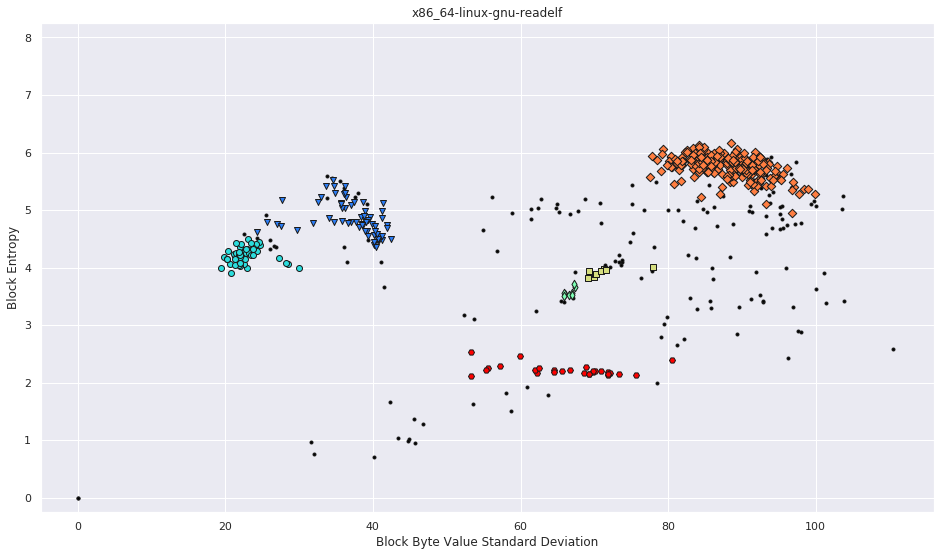

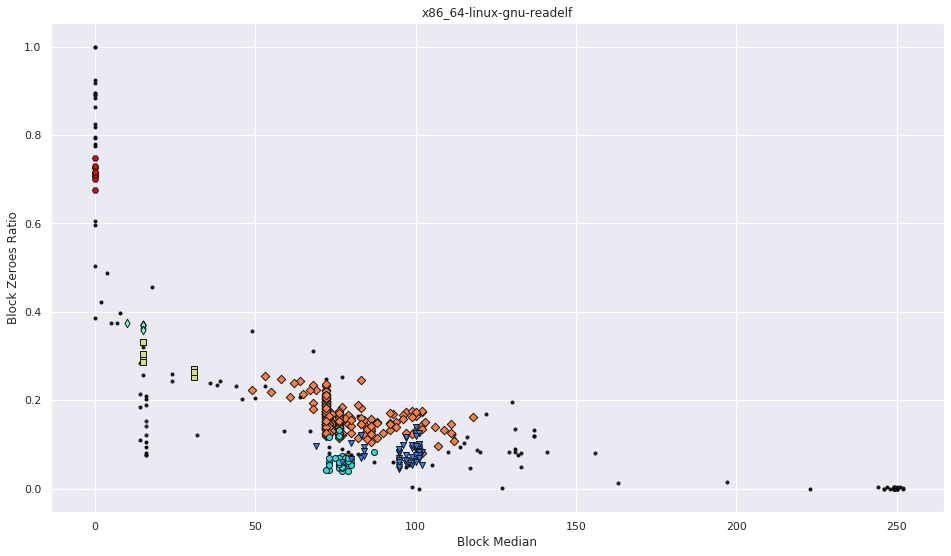

In [29]:
readelf.cluster_DBSCAN(0.5,
                       8,
                       find_optimal_epsilon=True)
readelf.plot_DBSCAN_results()

Looks good. Most clusters appear to have been identified and they are fairly cohesive. Analysis can now proceed.

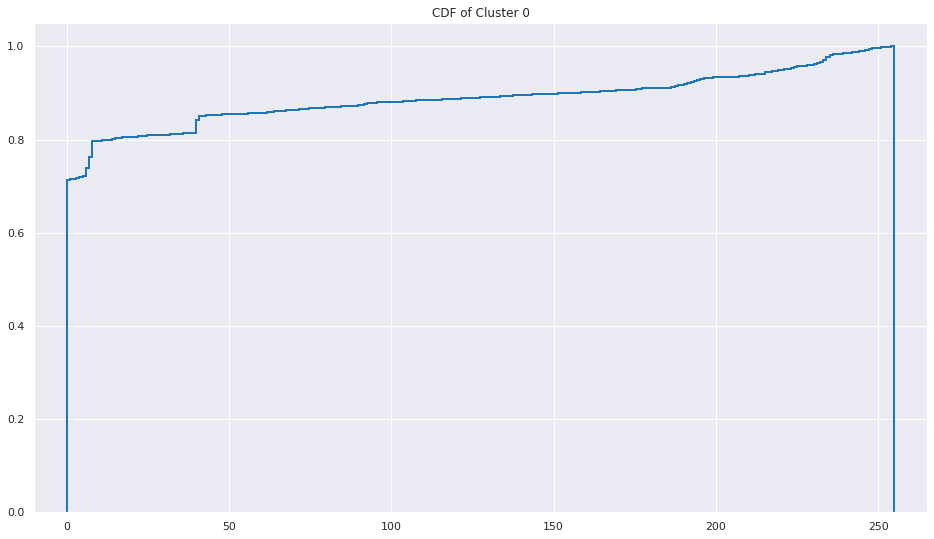

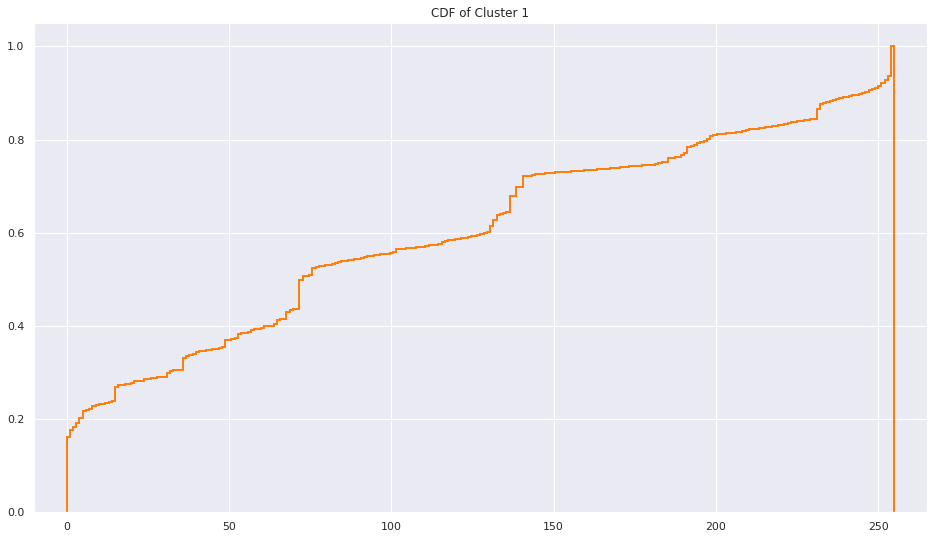

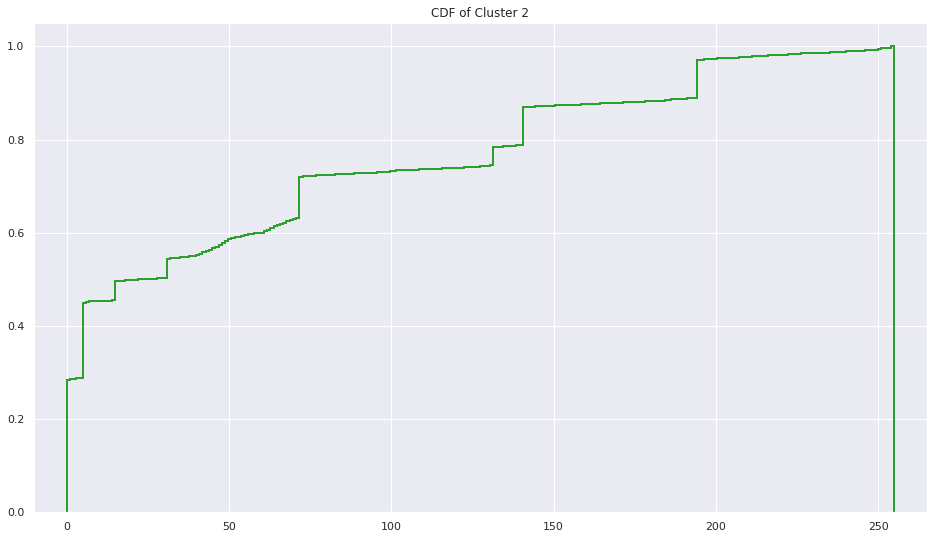

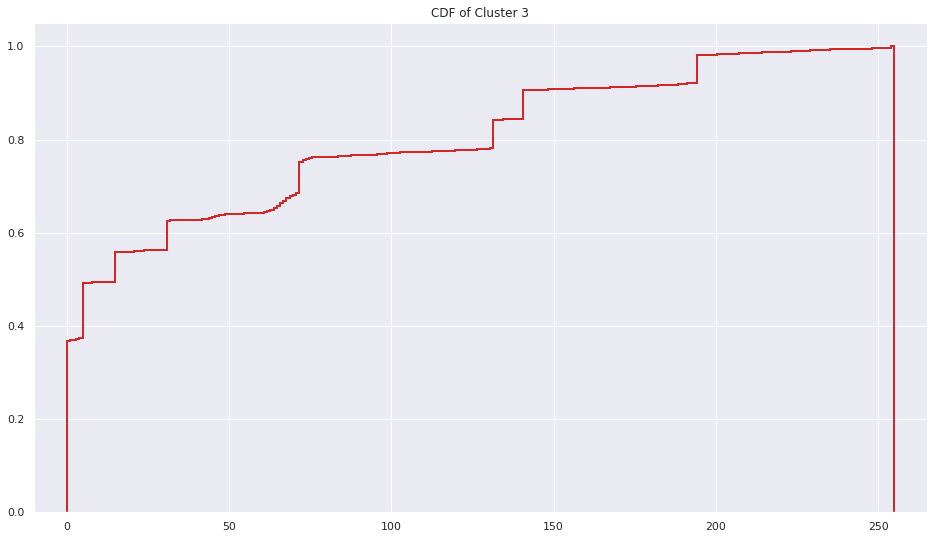

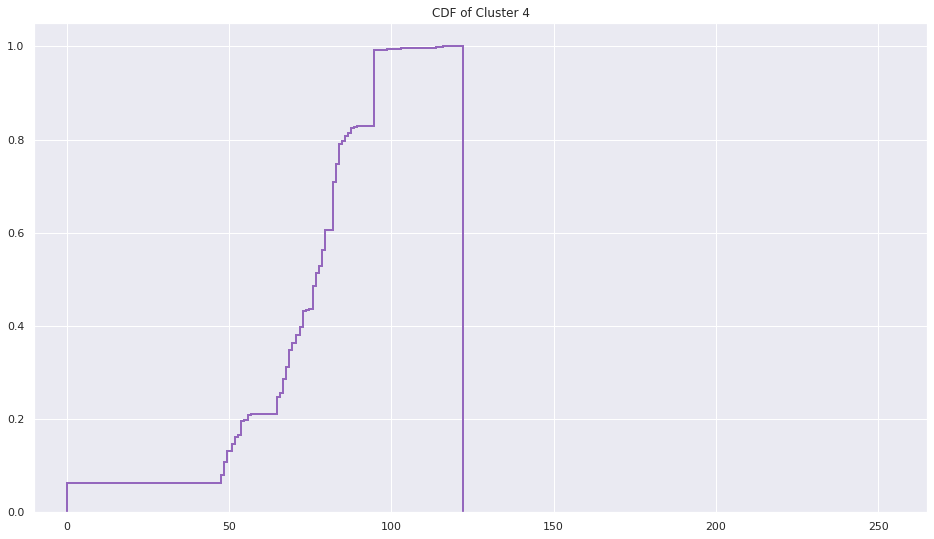

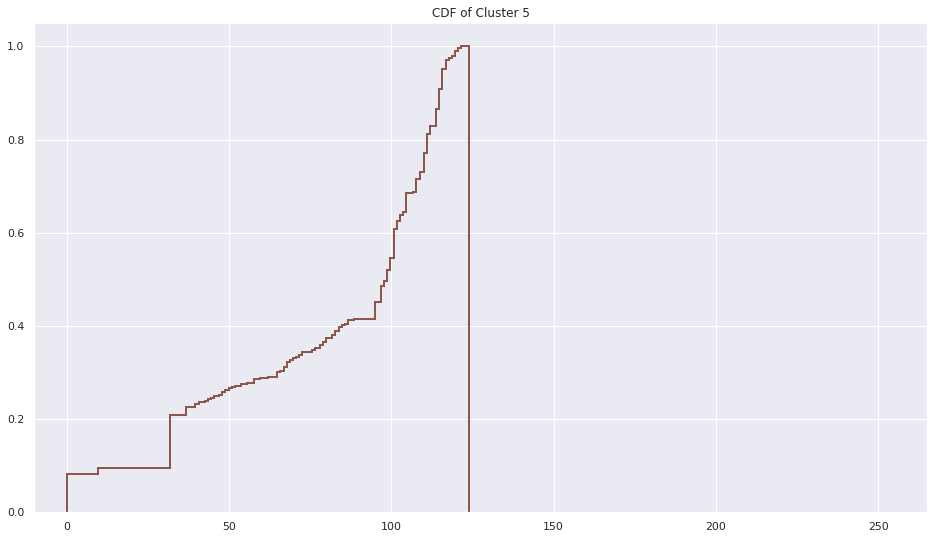

In [30]:
readelf.plot_cluster_cdfs()

In [31]:
_ = readelf.identify_cluster_data_types()

Searching for machine code
--------------------------------------------------------------------

[+] Checking Cluster 1 for possible match
[+] Closely matching CPU architecture reference(s) found for Cluster 1
[+] Sending sample to https://isadetect.com/
[+] response:

{
    "prediction": {
        "architecture": "amd64",
        "endianness": "little",
        "wordsize": 64
    },
    "prediction_probability": 0.97
}


Searching for utf8-english data
-------------------------------------------------------------------

[+] UTF-8 (english) detected in Cluster 4
    Wasserstein distance to reference: 27.24485186298077

[+] UTF-8 (english) detected in Cluster 5
    Wasserstein distance to reference: 11.126060697115385


Searching for high entropy data
-------------------------------------------------------------------

[X] No high entropy data cluster detected.

